### Future Sales - Deep Learning
###### [Mission] predicting future sales<br>[Data]<br>1) sales_train: daily historical data for shop and item(shop_id, item_id...)<br>2) Test<br>3) items: supplemental information about the items<br>3) item_categories:supplemental information about the items categories<br>4) shops: supplemental information about the shops

### Prepare data

In [1]:
# base
import pandas as pd
import numpy as np

# time
from datetime import datetime, date
from dateutil.relativedelta import relativedelta

# visualization
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

# deep learning
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from math import ceil
from keras.callbacks import LambdaCallback
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop

# acquire data
submission_data = pd.read_csv('C:/Users/1004/git/kaggle/Future Sales/sample_submission.csv')
train_data = pd.read_csv('C:/Users/1004/git/kaggle/Future Sales/sales_train.csv')
test_data = pd.read_csv('C:/Users/1004/git/kaggle/Future Sales/test.csv')
items = pd.read_csv('C:/Users/1004/git/kaggle/Future Sales/items.csv')
item_ctg = pd.read_csv('C:/Users/1004/git/kaggle/Future Sales/item_categories.csv')
shops = pd.read_csv('C:/Users/1004/git/kaggle/Future Sales/shops.csv')

### Analyze by describing data

In [2]:
test_shops = test_data.shop_id.unique()
train = train_data[train_data.shop_id.isin(test_shops)]
test_items = test_data.item_id.unique()
train = train_data[train_data.item_id.isin(test_items)]

In [3]:
MAX_BLOCK_NUM = train_data.date_block_num.max()
MAX_ITEM = len(test_items)
MAX_CTG = len(item_ctg)
MAX_YEAR = 3
MAX_MONTH = 4 # 7 8 9 10
MAX_SHOP = len(test_shops)


In [4]:
train_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


<h6>
* Notedate<br>- item_cnt_day: number of products sold<br>- block_num: a consecutive month number(Jan 2013 = 0, Feb 2013 = 1,..., Oct 2015 = 33)
</h6>

In [5]:
test_data.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [6]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [7]:
item_ctg.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [8]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [9]:
train_data.dtypes

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

### Analyze by pivoting features

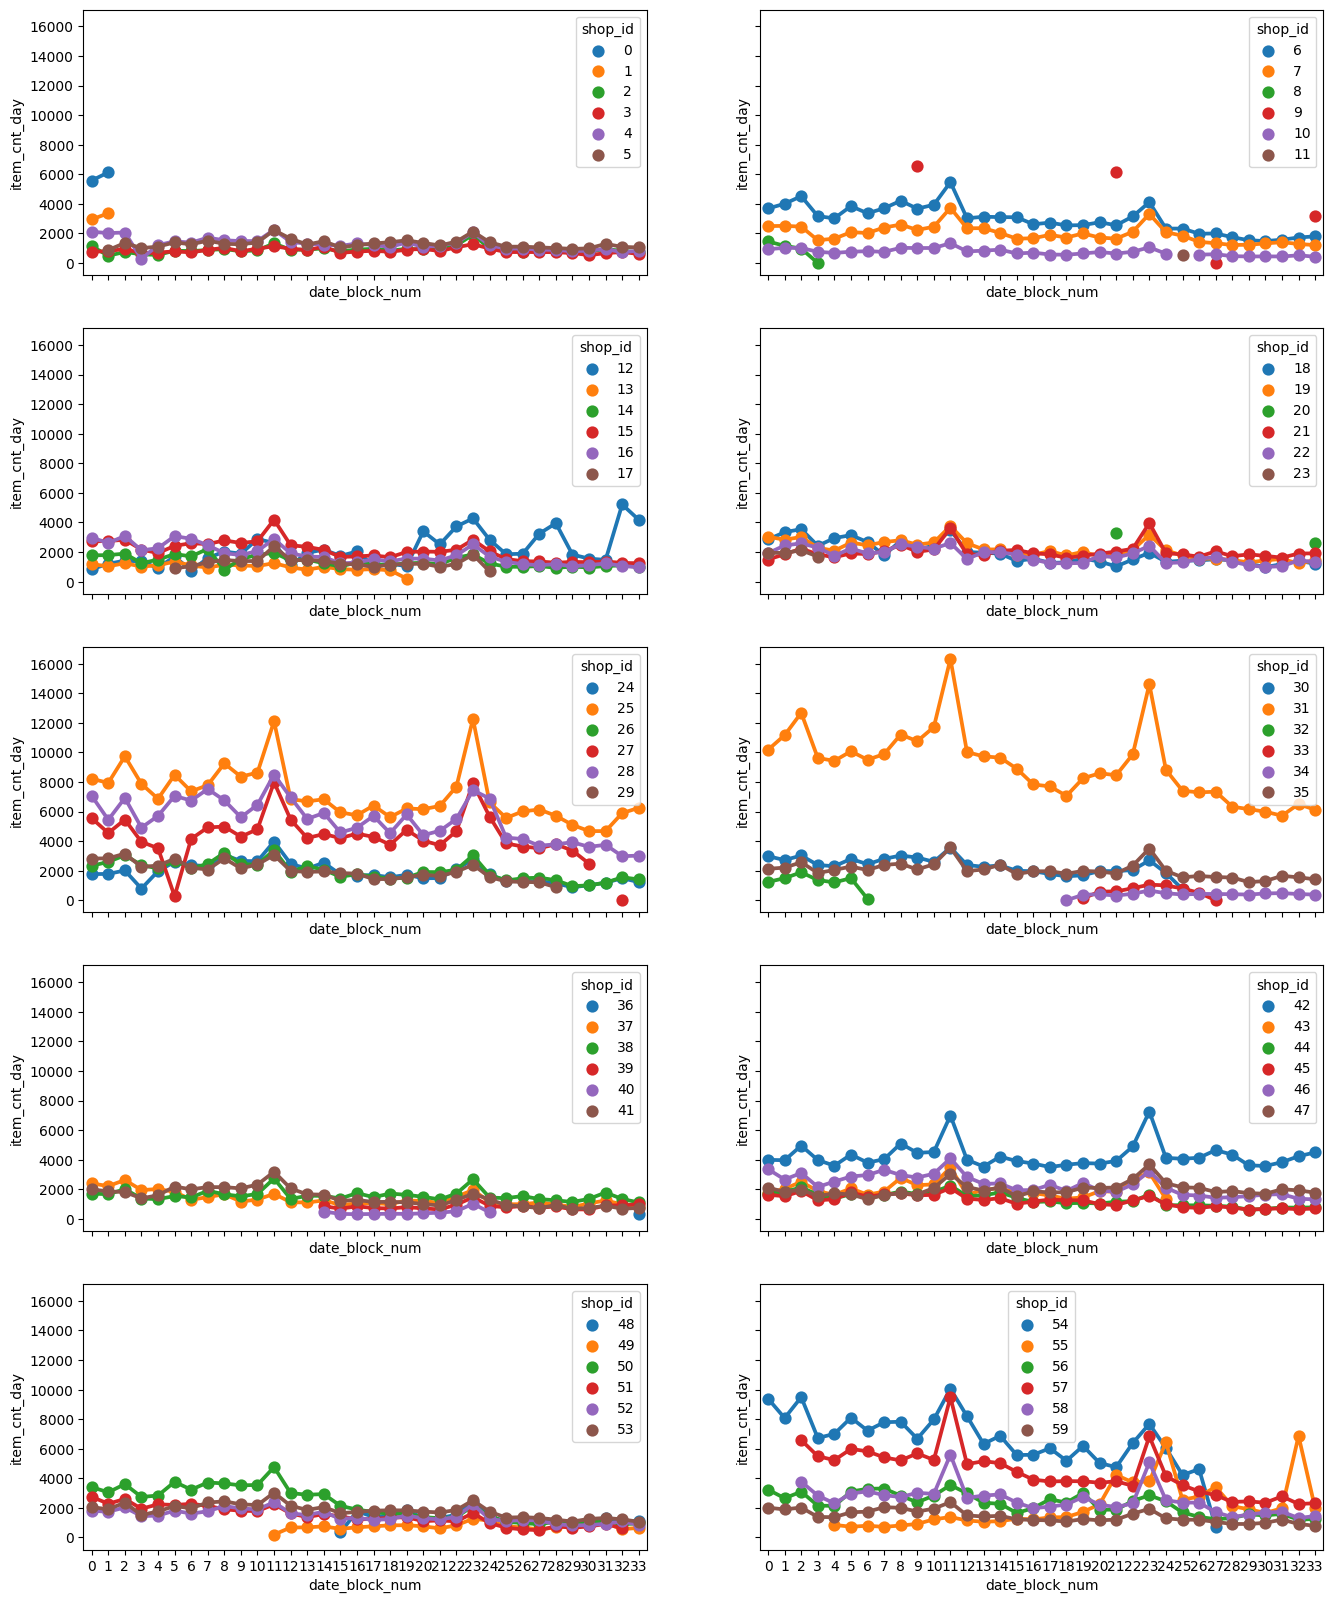

In [10]:
grouped = pd.DataFrame(train_data.groupby(['shop_id', 'date_block_num'])['item_cnt_day'].sum().reset_index())
fig, axes = plt.subplots(nrows = 5, ncols = 2, sharex = True, sharey = True, figsize = (16, 20))
num_graph = 10
id_per_graph = ceil(grouped.shop_id.max() / num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x = 'date_block_num', y = 'item_cnt_day', hue = 'shop_id', data = grouped[np.logical_and(count*id_per_graph <= grouped['shop_id'], grouped['shop_id'] < (count+1)*id_per_graph)], ax = axes[i][j])
        count += 1

<h6>
* Note(graph summary)<br>
- the end of the year is a peak season(holiday season)<br>
- so, add month of year
</h6>

In [11]:
# create new features
train_data = train_data.set_index('item_id').join(items.set_index('item_id')).drop('item_name', axis = 1).reset_index()

In [12]:
train_data['month'] = train_data.date.apply(lambda x: datetime.strptime(x, '%d.%m.%Y').strftime('%m'))
train_data['year'] = train_data.date.apply(lambda x: datetime.strptime(x, '%d.%m.%Y').strftime('%Y'))

In [13]:
train_data

,item_id,date,date_block_num,shop_id,item_price,item_cnt_day,item_category_id,month,year
0,0,01.09.2014,20,54,58.0,1.0,40,09,2014
1,1,04.04.2014,15,55,4490.0,1.0,76,04,2014
2,1,02.04.2014,15,55,4490.0,1.0,76,04,2014
3,1,06.07.2014,18,55,4490.0,1.0,76,07,2014
4,1,04.08.2014,19,55,4490.0,1.0,76,08,2014
...,...,...,...,...,...,...,...,...,...
2935844,22168,02.02.2013,1,42,799.0,1.0,62,02,2013
2935845,22168,17.02.2013,1,16,799.0,1.0,62,02,2013
2935846,22168,08.03.2013,2,43,798.5,1.0,62,03,2013
2935847,22168,13.09.2013,8,12,799.0,1.0,62,09,2013


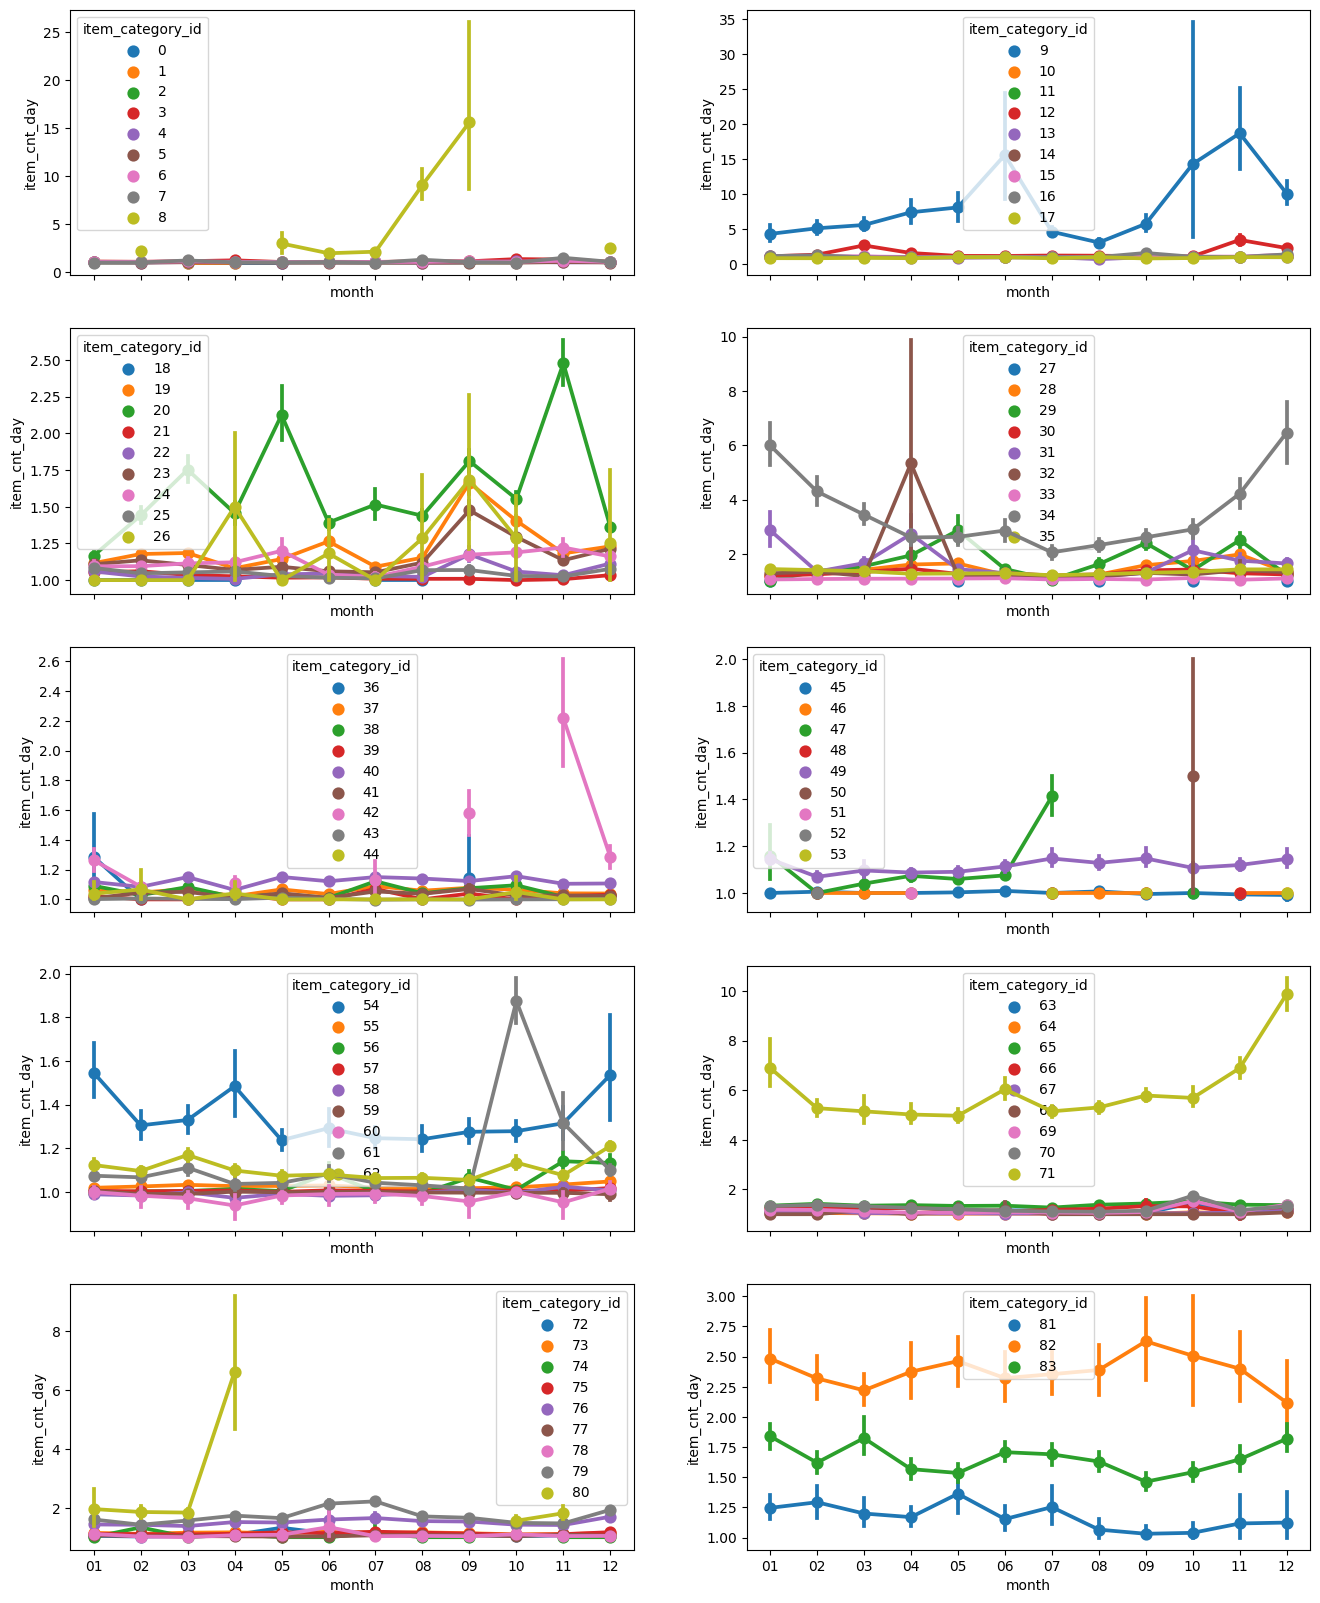

In [14]:
fig, axes = plt.subplots(nrows = 5, ncols = 2, sharex = True, figsize = (16, 20))
num_graph = 10
id_per_graph = ceil(train_data.item_category_id.max() / num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x = 'month', y = 'item_cnt_day', hue = 'item_category_id', data = train_data[np.logical_and(count*id_per_graph <= train_data['item_category_id'], train_data['item_category_id'] < (count+1) * id_per_graph)], ax = axes[i][j])
        count += 1

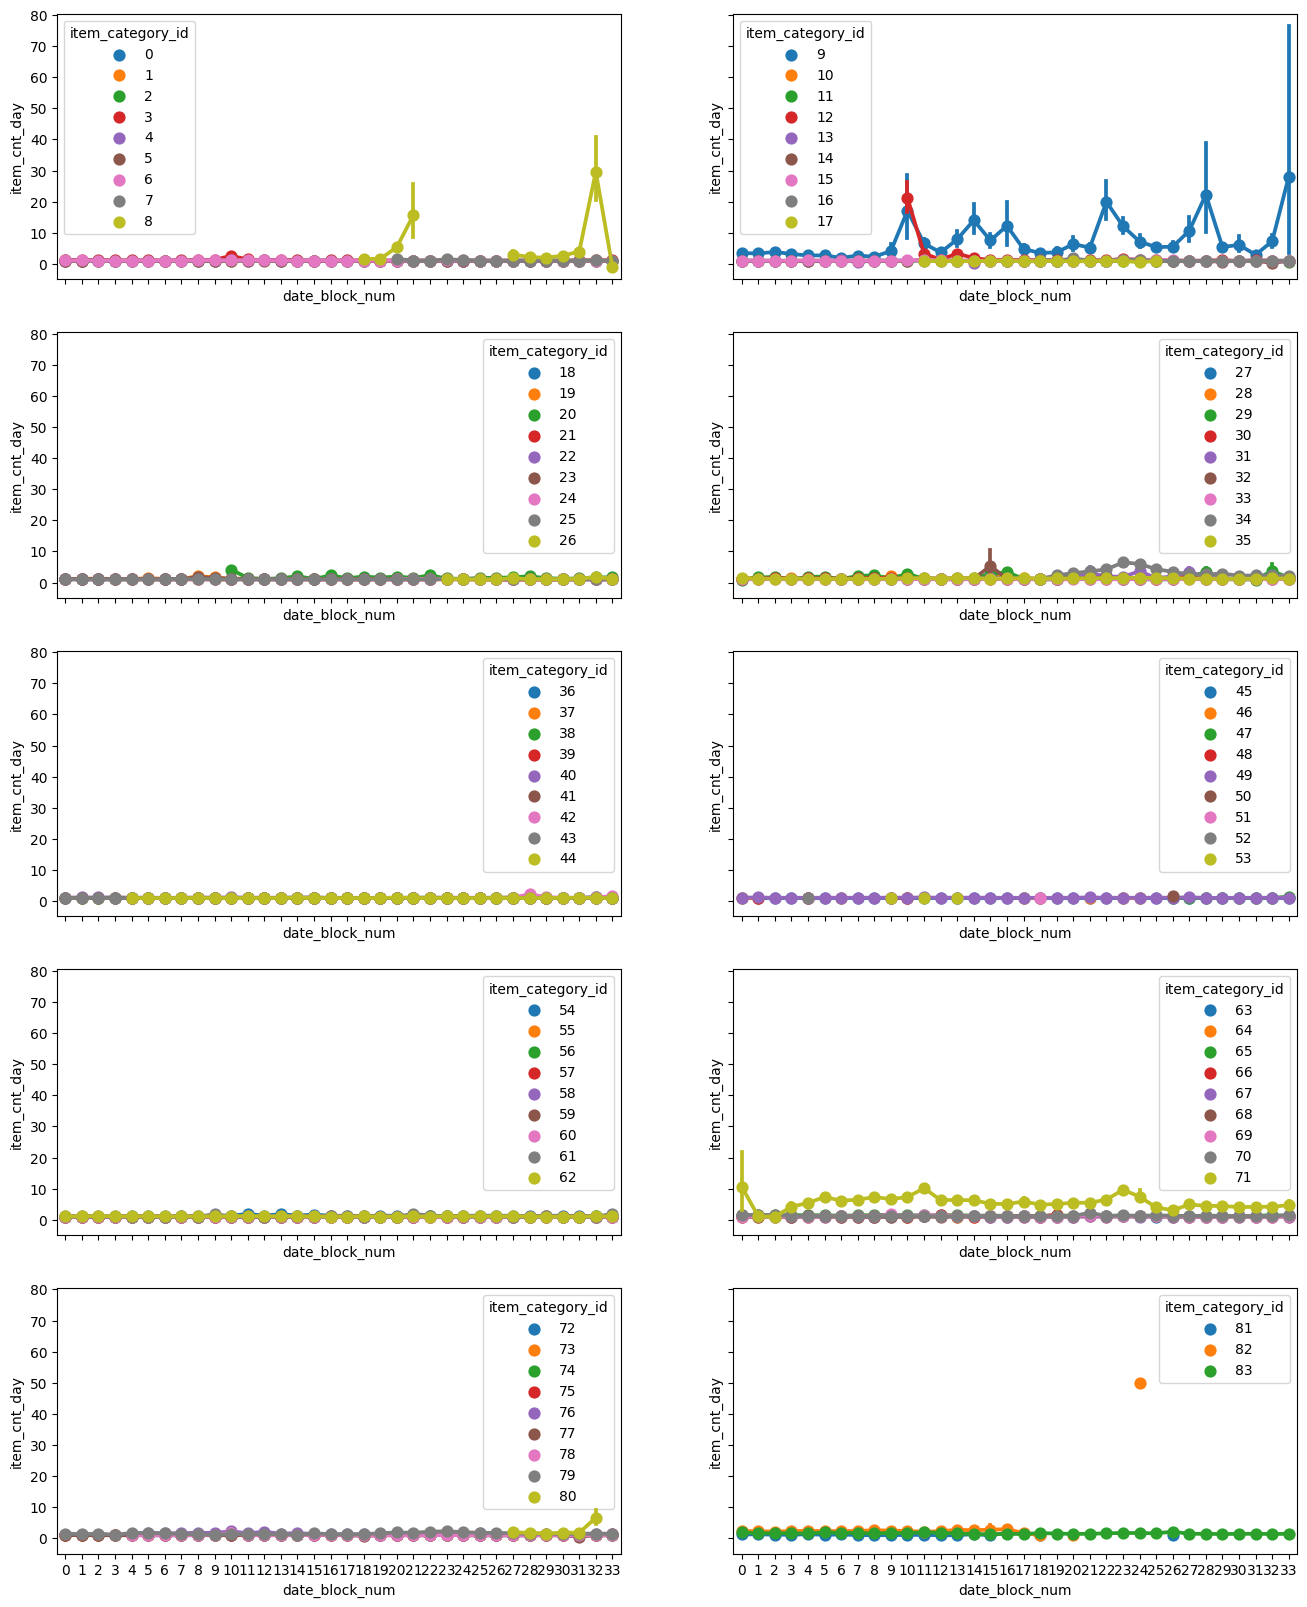

In [15]:
fig, axes = plt.subplots(nrows = 5, ncols = 2, sharex = True, sharey = True, figsize = (16, 20))
num_graph = 10
id_per_graph = ceil(train_data.item_category_id.max()/ num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x = 'date_block_num', y = 'item_cnt_day', hue = 'item_category_id', data = train_data[np.logical_and(count*id_per_graph <= train_data['item_category_id'], train_data['item_category_id'] < (count+1)*id_per_graph)], ax = axes[i][j])
        count += 1

In [16]:
train_data = train_data.drop('date', axis = 1)
train_data = train_data.drop('item_category_id', axis = 1)
train_data = train_data.groupby(['shop_id', 'item_id', 'date_block_num', 'month', 'year']).sum()
train_data = train_data.sort_index()

In [17]:
train_data

item_price  item_cnt_day
shop_id item_id date_block_num month year                          
0       30      1              02    2013      2385.0          31.0
        31      1              02    2013      3038.0          11.0
        32      0              01    2013       884.0           6.0
                1              02    2013      1547.0          10.0
        33      0              01    2013      1041.0           3.0
...                                               ...           ...
59      22164   27             04    2015      1398.0           2.0
                30             07    2015       699.0           1.0
        22167   9              10    2013       299.0           1.0
                11             12    2013       598.0           2.0
                17             06    2014       299.0           1.0

[1609124 rows x 2 columns]

### Model, prediect and solve

In [18]:
scaler = StandardScaler()
cnt_scaler = StandardScaler()

scaler.fit(train_data.item_price.to_numpy().reshape(-1, 1))
cnt_scaler.fit(train_data.item_cnt_day.to_numpy().reshape(-1, 1))

train_data.item_price = scaler.transform(train_data.item_price.to_numpy().reshape(-1, 1))
train_data.item_cnt_day = cnt_scaler.transform(train_data.item_cnt_day.to_numpy().reshape(-1, 1))

In [19]:
train_data

item_price  item_cnt_day
shop_id item_id date_block_num month year                          
0       30      1              02    2013    0.133232      3.321757
        31      1              02    2013    0.247761      1.009586
        32      0              01    2013   -0.130027      0.431544
                1              02    2013   -0.013744      0.893978
        33      0              01    2013   -0.102491      0.084718
...                                               ...           ...
59      22164   27             04    2015   -0.039877     -0.030891
                30             07    2015   -0.162474     -0.146499
        22167   9              10    2013   -0.232630     -0.146499
                11             12    2013   -0.180188     -0.030891
                17             06    2014   -0.232630     -0.146499

[1609124 rows x 2 columns]

In [20]:
train_data.reset_index().groupby(['item_id', 'date_block_num', 'shop_id']).mean()

item_price  item_cnt_day
item_id date_block_num shop_id                          
0       20             54        -0.274898     -0.146499
1       15             55         1.289923     -0.030891
        18             55         0.502426     -0.146499
        19             55         0.502426     -0.146499
        20             55         0.502426     -0.146499
...                                    ...           ...
22168   1              16        -0.144935     -0.146499
                       42        -0.144935     -0.146499
        2              43        -0.145023     -0.146499
        8              12        -0.144935     -0.146499
22169   14             25         0.477696     -0.146499

[1609124 rows x 2 columns]

In [21]:
price = train_data.reset_index().set_index(['item_id', 'shop_id', 'date_block_num'])
price = price.sort_index()

In [22]:
price

month  year  item_price  item_cnt_day
item_id shop_id date_block_num                                      
0       54      20                09  2014   -0.274898     -0.146499
1       55      15                04  2014    1.289923     -0.030891
                18                07  2014    0.502426     -0.146499
                19                08  2014    0.502426     -0.146499
                20                09  2014    0.502426     -0.146499
...                              ...   ...         ...           ...
22168   12      8                 09  2013   -0.144935     -0.146499
        16      1                 02  2013   -0.144935     -0.146499
        42      1                 02  2013   -0.144935     -0.146499
        43      2                 03  2013   -0.145023     -0.146499
22169   25      14                03  2014    0.477696     -0.146499

[1609124 rows x 4 columns]

In [23]:
def convert(date_block):
    date = datetime(2013, 1, 1)
    date += relativedelta(months = date_block)
    return (date.month, date.year)

def closest_date_block(current_day, item_id, shop_id):
    if (item_id, shop_id) in price.index:
        search_1st = np.array(price.loc[(item_id, shop_id)].index)
        return search_1st[np.abs(current_day - search_1st).argmin()]
    return -1

def closest_price(current_day, item_id, shop_id):
    closest_date = closest_date_block(current_day, item_id, shop_id)
    if closest_date != -1:
        return price.loc[(item_id, shop_id, closest_date)]['item_price']
    return np.nan

def closest_price_lambda(x):
    return closest_price(34, x.item_id, x.shop_id)


In [24]:
assert closest_date_block(18, 30, 5) == 18

In [25]:
print(convert(6))
print(convert(18))
print(convert(30))

(7, 2013)
(7, 2014)
(7, 2015)


In [29]:
maxlen = 4
step = 1
# 0: train, 1: val, 2: test
sentences = [[], [], []]
next_chars = [[], []]
BLOCKS = [6, 18, 30]

for s in test_shops:
    shop_items = list(train_data.loc[s].index.get_level_values(0).unique())
    for it in shop_items:
        for i_index, i in enumerate(BLOCKS):
            sentence = []
            closest_pc = closest_price(i, it, s)
            for j in range(maxlen+1):
                if j < maxlen:
                    if (s, it, i+j) in train_data.index:
                        r = train_data.loc[(s, it, i+j)].to_dict(orient = 'list')
                        closest_pc = r['item_price'][0]
                        item_cnt_day = r['item_cnt_day'][0]
                        row = {'shop_id':s, 'date_block_num':i+j, 'item_cnt_day':item_cnt_day, 'month':month, 'item_id':it, 'item_price':closest_pc, 'year':year}
                    else:
                        month, year = convert(i+j)
                        row = {'shop_id':s, 'date_black_num':i+j, 'item_cnt_day':closest_pc, 'year':year}
                        sentence.append(row)
                elif i_index < 2:
                    next_chars[i_index].append(row)
            sentences[i_index].append(sentence)

In [28]:
X_train_o = np.array(sentences[0])
X_val_o = np.array(sentences[1])
X_test_o = np.array(sentences[2])
Y_train = np.array([X['item_cnt_day'] for X in next_chars[0]])
Y_val = np.array([X['item_cnt_day'] for X in next_chars[1]])

NameError: name 'sentence' is not defined

In [ ]:
length = MAX_SHOP + MAX_ITEM + MAX_MONTH + 1 + 1 + 1

In [ ]:
shop_le = preprocessing.LabelEncoder()
shop_le.fit(test_shops)
shop_dm = dict(zip(test_shops, shop_le.transform(test_shops)))

item_le = preprocessing.LabelEncoder()
item_le.fit(test_items)
item_dm = dict(zip(test_items, item_le.transform(test_items)))

month_le = preprocessing.LabelEncoder()
month_le.fit(range(7, 11))
month_dm = dict(zip(range(7, 11), month_le.transfrom(range(7, 11))))

In [ ]:
def vectorize(inp):
    print('Vectorizatioin...')
    x = np.zeros((len(inp), maxlen, length), dtype = np.float32)
    for i, sentence in enumerate(inp):
        for t, char in enumerate(sentence):
            x[i][t][shop_dm[char['shop_id']]] = 1
            x[i][t][MAX_SHOP + item_dm[char['item_id']]] = 1
            x[i][t][MAX_SHOP + MAX_ITEM + month_dm[char['month']]] = 1
            x[i][t][MAX_SHOP + MAX_ITEM + MAX_MONTH + 1] = char['item_price']
            x[i][t][MAX_SHOP + MAX_ITEM + MAX_MONTH + 1 + 1] = char['item_cnt_day']
    return x

In [ ]:
X_train = vectorize(X_train_o)
X_val = vectorize(X_val_o)
X_test = vectorize(X_test_o)

In [ ]:
# LSTM
model = Sequential()
model.add(LSTM(32, input_shape = (maxlen, length)))
model.add(Dense(1, activation = 'relu'))

optimizer = RMSprop(lr = 0.005)
model.complie(loss = 'mean_squared_error', optimizer = optimizer)

model.fit(X_train, Y_train, batch_size = 128, epochs = 13)

In [ ]:
model.fit(X_val, Y_val, batch_size = 128, epochs = 13)

In [ ]:
predict_test = model.predict(X_test)
predict_test = cnt_scaler.inverse_transform(predict_test)

In [ ]:
test_data = test_data.set_index(['shop_id', 'item_id'])
test_data['item_cnt_month'] = 0

In [ ]:
for index, sentence in enumerate(X_test_o):
    (shop_id, item_id) = (sentence[0]['shop_id'], sentence[0]['item_id'])
    test_data.loc[(shop_id, item_id)]['item_cnt_month'] = predict_test[index]

In [ ]:
test_data = test_data.reset_index().drop(['shop_id', 'item_id'], axis = 1)
test_data.to_csv('submission.csv', index = False)

###### * 아래 링크를 참고 했으며, 개인적인 공부를 위한 코드입니다.<br>참고) https://www.kaggle.com/code/minhtriet/a-beginner-guide-for-sale-data-prediction